# Demo of the GTM Magic Analysis for Conditional Independence

In this demonstration we analyze the optimal GTM number of decorrelation layers for the hadron and gamma classes based on the optimal models chosen in the notebook [demo_magic_classification](demos/demo_magic_classification.ipynb).

In [1]:
# GTM Package including GTM and the plot functions
from gtm import *

import os
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from demos.load_analyze_magic_data_helpers import *
from demos.dataset_helpers import Generic_Dataset

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# got up one directory as new working directory so that loading data works
# only run this once
os.chdir(os.path.dirname(os.getcwd()))

#### Loading the Data and Models to cpu

In [3]:
group = "h"

y_train_group_h, y_validate_group_h, y_test_group_h = load_magic_data(
    group=group,
    train_portion=2 / 3,
    data_dims=10,
    poly_span_abs=12,
    cross_validation_folds=5,
    validation_fold_index=4,
    split_random_state=25,
)

In [4]:
group = "g"

y_train_group_g, y_validate_group_g, y_test_group_g = load_magic_data(
    group=group,
    train_portion=2 / 3,
    data_dims=10,
    poly_span_abs=12,
    cross_validation_folds=5,
    validation_fold_index=4,
    split_random_state=25,
)

In [5]:
group = "h"
num_decorr_layers = 8
loaded_model_h = torch.load(
    os.path.join(
        "demos",
        "models",
        f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth",
    ),
    map_location=torch.device("cpu"),
)
loaded_model_h = loaded_model_h.to("cpu")

group = "g"
num_decorr_layers = 6
loaded_model_g = torch.load(
    os.path.join(
        "demos",
        "models",
        f"magic_group_{group}_decorr_{num_decorr_layers}_gtm_state_dict.pth",
    ),
    map_location=torch.device("cpu"),
)
loaded_model_g = loaded_model_g.to("cpu")

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_13788/872575049.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_h = torch.load(os.path.join("demo

In [6]:
loaded_model_h.approximate_transformation_inverse()

In [7]:
loaded_model_g.approximate_transformation_inverse()

## Computing the Conditional Independence Tables for both class GTMs

Theses tables include the pseudo correlation matrix metrics for conditional dependence such as `precision_abs_mean`, `precision_square_mean`, `cond_correlation_abs_mean`	and `cond_correlation_square_mean` as well as the exact likelihood based metrics `iae` and `kld`. You can find more details in the Paper. The key thing to remember is that only the likelihood based metrics measure conditionalndependence exactly, hence if they are zero the model has learned exact condtional independence between two dimenesions given the others.

For the likelihood based metrics we need to compute quadratures, hence we need to define an interval for the quadrature. We simply look at the min and max values across all dimensions in the data and then make the bounds a but larger. As the computations take a bit of time ,for onvinience we have stored the tables to load.

In [8]:
print(loaded_model_h.after_transformation(y_train_group_h).min())
print(loaded_model_h.after_transformation(y_train_group_h).max())
print(loaded_model_g.after_transformation(y_train_group_g).min())
print(loaded_model_g.after_transformation(y_train_group_g).max())

tensor(-7.2337, grad_fn=<MinBackward1>)
tensor(8.6070, grad_fn=<MaxBackward1>)
tensor(-7.9207, grad_fn=<MinBackward1>)
tensor(10.6438, grad_fn=<MaxBackward1>)


In [9]:
# Path to where the table will be stored
table_path = os.path.join(
    "demos", "ci_tables", "conditional_independence_table_group_h.csv"
)

# Check if the file exists
if os.path.exists(table_path):
    # Load the existing table
    conditional_independence_table_h = pd.read_csv(table_path, index_col=0)
    loaded_model_h.conditional_independence_table = conditional_independence_table_h
else:
    # Compute the table
    conditional_independence_table_h = (
        loaded_model_h.compute_conditional_independence_table(
            y=None,
            x=False,
            evaluation_data_type="samples_from_model",
            num_processes=4,
            sample_size=10000,
            num_points_quad=20,
            optimized=True,
            copula_only=True,
            min_val=-8,
            max_val=10,
        )
    )

    # Ensure the target directory exists
    os.makedirs(os.path.dirname(table_path), exist_ok=True)

    # Save the table
    conditional_independence_table_h.to_csv(table_path)

First we look at the correlations between the different metrics to notice that they are quite smlar, especially the likelihood based metrics.

In [10]:
conditional_independence_table_h.corr("spearman")

,index,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae
index,1.000000,0.989071,0.589047,-0.637154,-0.643215,-0.247431,-0.254941,-0.254414,-0.340053
var_row,0.989071,1.000000,0.468889,-0.611026,-0.615089,-0.228585,-0.235046,-0.235579,-0.325228
var_col,0.589047,0.468889,1.000000,-0.488474,-0.506591,-0.273410,-0.287996,-0.262953,-0.281535
precision_abs_mean,-0.637154,-0.611026,-0.488474,1.000000,0.991963,0.679447,0.677602,0.629644,0.717918
precision_square_mean,-0.643215,-0.615089,-0.506591,0.991963,1.000000,0.674308,0.681159,0.651779,0.734651
cond_correlation_abs_mean,-0.247431,-0.228585,-0.273410,0.679447,0.674308,1.000000,0.991568,0.842029,0.877602
cond_correlation_square_mean,-0.254941,-0.235046,-0.287996,0.677602,0.681159,0.991568,1.000000,0.883663,0.909618
kld,-0.254414,-0.235579,-0.262953,0.629644,0.651779,0.842029,0.883663,1.000000,0.976021
iae,-0.340053,-0.325228,-0.281535,0.717918,0.734651,0.877602,0.909618,0.976021,1.000000


In [11]:
# Path to where the table will be stored
table_path = os.path.join(
    "demos", "ci_tables", "conditional_independence_table_group_g.csv"
)

# Check if the file exists
if os.path.exists(table_path):
    # Load the existing table
    conditional_independence_table_g = pd.read_csv(table_path, index_col=0)
    loaded_model_g.conditional_independence_table = conditional_independence_table_g
else:
    # Compute the table
    conditional_independence_table_g = (
        loaded_model_g.compute_conditional_independence_table(
            y=None,
            x=False,
            evaluation_data_type="samples_from_model",
            num_processes=4,
            sample_size=10000,
            num_points_quad=20,
            optimized=True,
            copula_only=True,
            min_val=-8,
            max_val=11,
        )
    )

    # Ensure the target directory exists
    os.makedirs(os.path.dirname(table_path), exist_ok=True)

    # Save the table
    conditional_independence_table_g.to_csv(table_path)

## Plotting Conditional Independence Graphs based on IAE without and with Pseudo Condonditional Correlation based Pairplots

In the following we show how easy it is to create conditional independence graphs with the GTM class plotting methods.
We show how to plot the conditional independence graph in a standard way as well as with overlaying pairplots to highlight the nonlinearity of the relationships.

### Hadron Data

There are 8 connections above  0.1


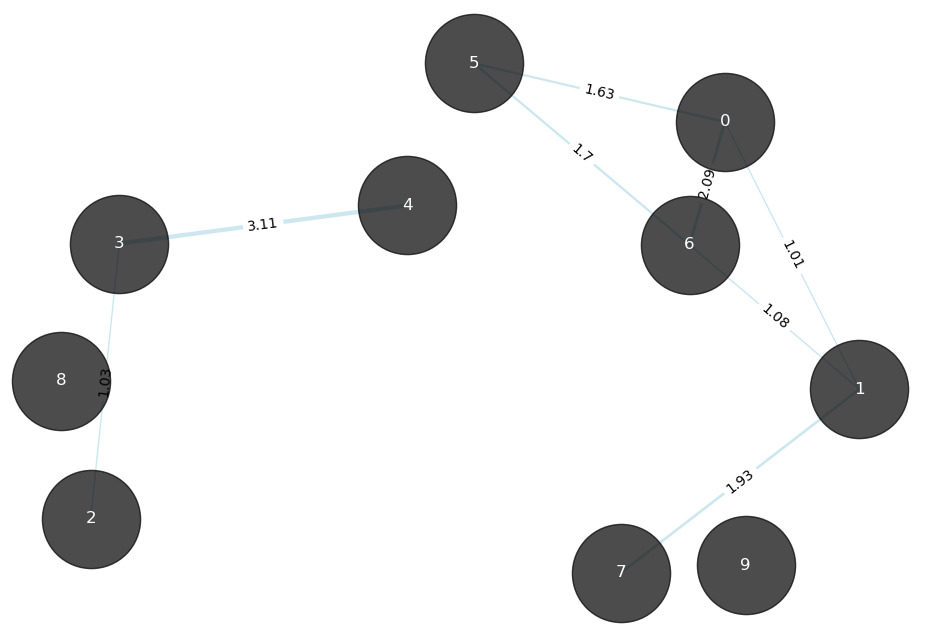

In [12]:
loaded_model_h.plot_conditional_dependence_graph(
    dependence_metric="iae",
    minimum_dependence_threshold=0.1,
    names=False,
    variables_move=None,
    variables_move_positions=None,
    k=1.5,
    seed_graph=42,
)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:526: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,


There are 8 connections above 0.1


/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


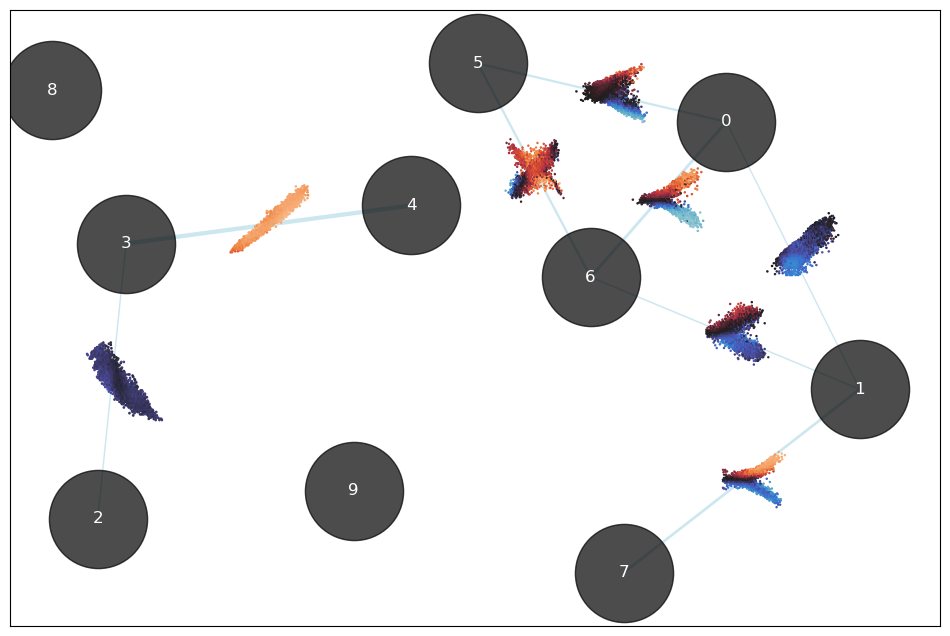

In [13]:
loaded_model_h.plot_conditional_dependence_graph(
    dependence_metric="iae",
    minimum_dependence_threshold=0.1,
    pair_plots=True,
    data=y_train_group_h.detach(),
    after_marginal_transformation=True,
    names=False,
    lim_axis_pairplots=[-9, 9],
    variables_move=[8, 9, 6],
    variables_move_positions=[(-1.0, 0.9), (-0.3, -0.6), (0.25, 0.2)],
    k=1.5,
    seed_graph=42,
)

### Gamma Data

There are 13 connections above  0.1


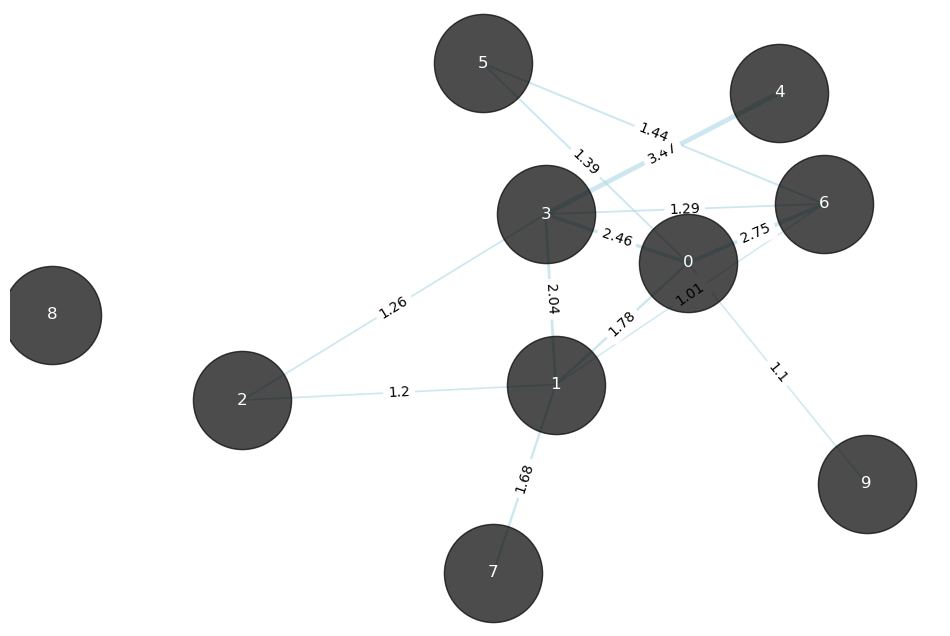

In [14]:
loaded_model_g.plot_conditional_dependence_graph(
    dependence_metric="iae",
    minimum_dependence_threshold=0.1,
    names=False,
    variables_move=None,
    variables_move_positions=None,
    k=1.5,
    seed_graph=42,
)

There are 13 connections above 0.1


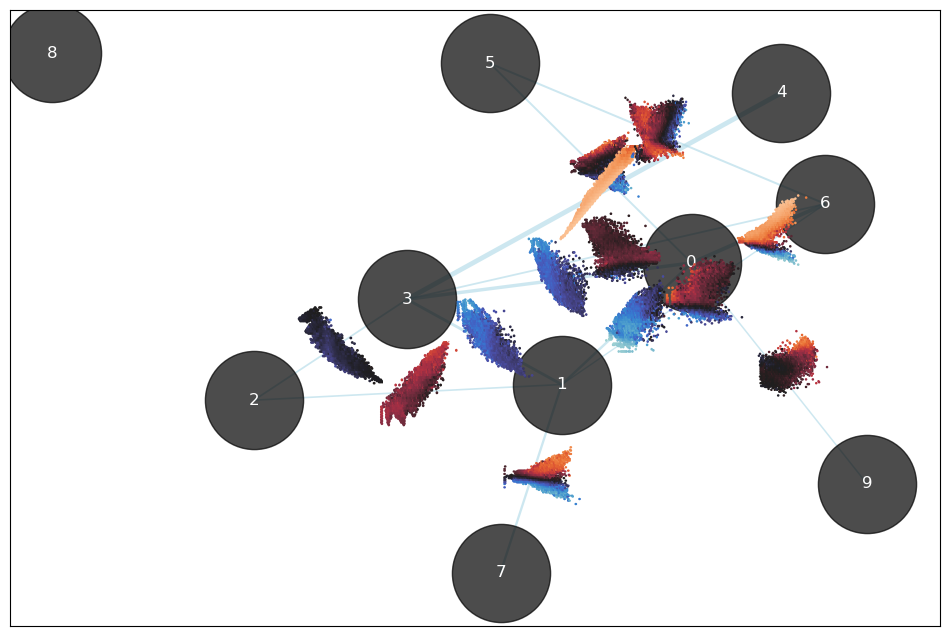

In [15]:
loaded_model_g.plot_conditional_dependence_graph(
    dependence_metric="iae",
    minimum_dependence_threshold=0.1,
    pair_plots=True,
    data=y_train_group_g.detach(),
    after_marginal_transformation=True,
    names=False,
    lim_axis_pairplots=[-9, 9],
    variables_move=[8, 3],
    variables_move_positions=[(-1.0, 0.9), (-0.3, 0.0)],
    k=1.5,
    seed_graph=42,
)

## Understanding the Nonlinear Conditional Dependencies

Since conditional dependencies can be nonlinear it is key to look at them to be able to interpret them. Herefor we provide the method `plot_conditional_dependence_structure` which uses the computed conditional dependence table to pick and sort dependencies accoridng to dependence metrics and then plots the pairplots overlaying the pseudo conditional correlations to interpret what is going on.
The data can be both plot before the marginal transformations hence in Y space and after marginal transformations in $\tilde{Z}$ space.


We plot all dependencies with an iae above 0.1 and ordered by the strength of there relationships.
Notice how the local pseudo conditional correlations explain local correlation patterns.

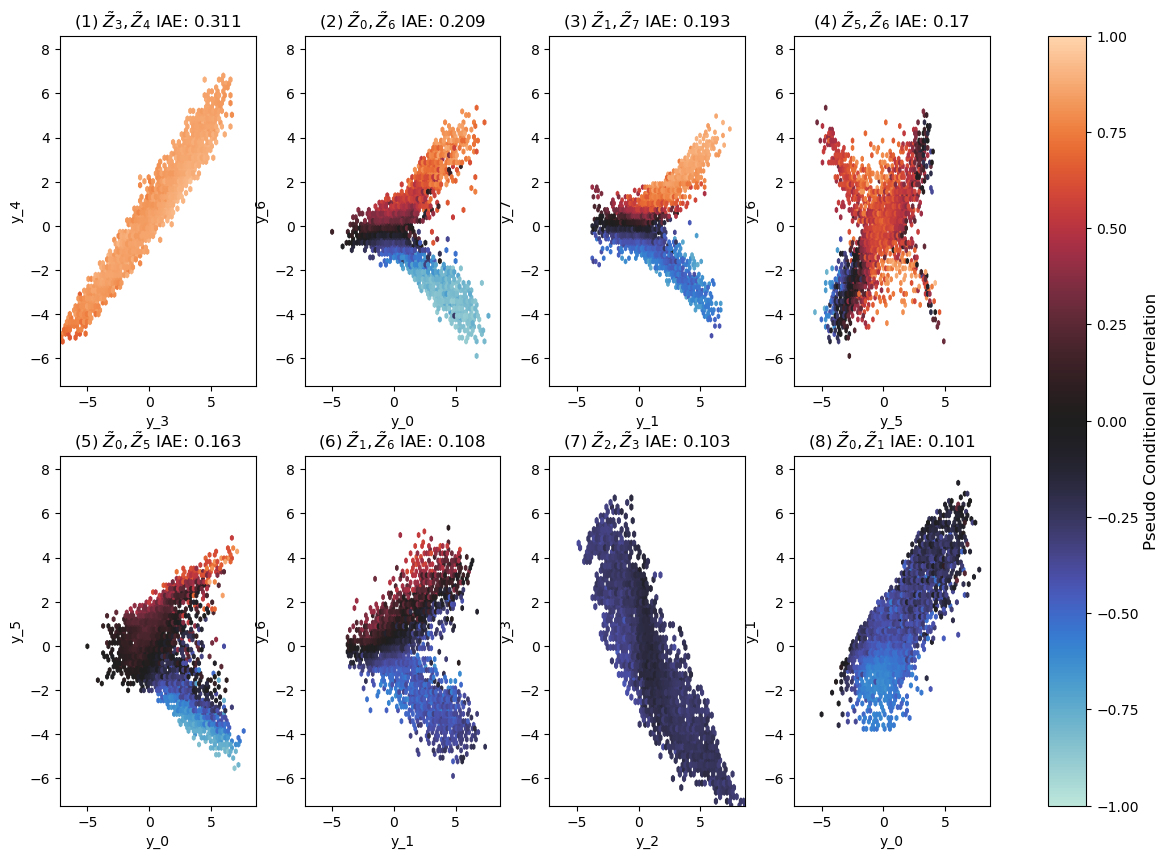

In [16]:
loaded_model_h.plot_conditional_dependence_structure(
    data=y_train_group_h.detach(),
    dependence_metric_threshholding="iae",
    minimum_dependence_threshold=0.1,
    after_marginal_transformation=True,
    show_colorbar=True,
    hide_axis_info=False,
    sub_title_fontsize=12,
    x_lim=None,
    y_lim=None,
)

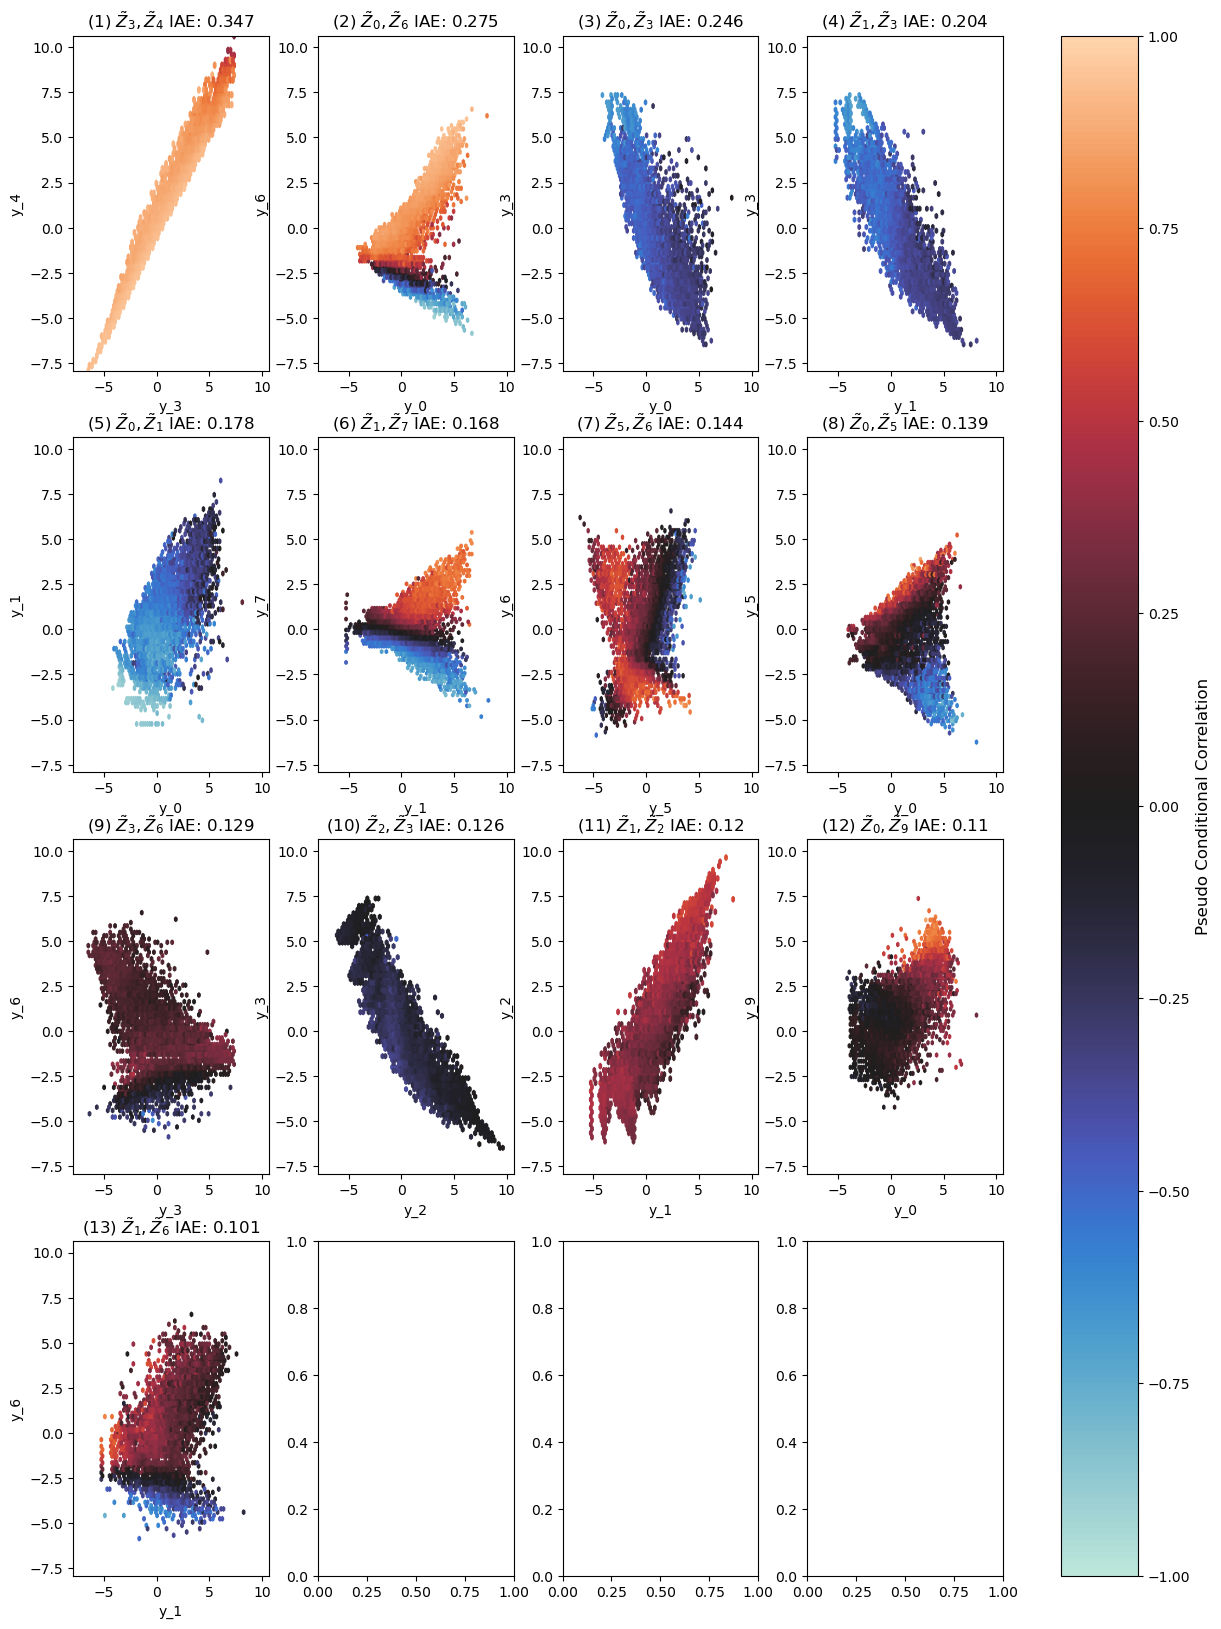

In [17]:
loaded_model_g.plot_conditional_dependence_structure(
    data=y_train_group_g.detach(),
    conditional_independence_table=conditional_independence_table_g,
    dependence_metric_threshholding="iae",
    minimum_dependence_threshold=0.1,
    after_marginal_transformation=True,
    show_colorbar=True,
    hide_axis_info=False,
    sub_title_fontsize=12,
    x_lim=None,
    y_lim=None,
)

## Understanding the Nonlinear Conditional Dependencies through local sampling

For most pairplots the pseudo conditional correlations explain the actual dependency patterns well. However in some cases it seems unclear why locally there is a positive or even negative relationship. This is the result of the pairplots showing unconditional data, hence each point in a pairplot depdns on different values of all other variables that are not visible.

Therefor it can be that through useen relationships with other variables that the dependencies are not so clear. To get a better visual understanding it is sensible to sample synthetically 2 variables while keeping all other varaibles fixed. We provide a method `conditional_sample` that relies on a n importance sampling approach to do this.
The resulting plots then show the full varaition in the synthetic data as all not seen dmensions are fixed.

Below we take two example data points for the hadron data from the training set to visualize this. We plot the synthetic samples density as well as pseudo conditional correlations both in $Y$ and marginally transformed $\tilde{Z}$ space. The two examples for dimensions (0,1) and (5,6) are chosen because in the pairplots the negative and positive realtionships are not so clear, however once conditioning they become much clearer and match what the pseudo correlation matrix reports.

In [18]:
point_to_investigate = torch.FloatTensor(
    [
        -13.81944592,
        -13.39484714,
        -11.96498054,
        4.22107939,
        -0.97419929,
        -0.6324696,
        3.14861005,
        -1.63705064,
        -12.85096667,
        -5.3661742,
    ]
)

sample_indices = [0, 1]
fixed_values = dict()
for idx in range(0, 10):
    if idx not in sample_indices:
        fixed_values[idx] = point_to_investigate[idx]

In [19]:
resampled_samples = loaded_model_h.conditional_sample(
    number_proposed_samples=100000,
    sample_indices=[0, 1],
    sample_ranges=[(-15, -9), (-15, -9)],
    fixed_values=fixed_values,
)

2540 samples where accepted.


/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_conditional_dependence_pair.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so 

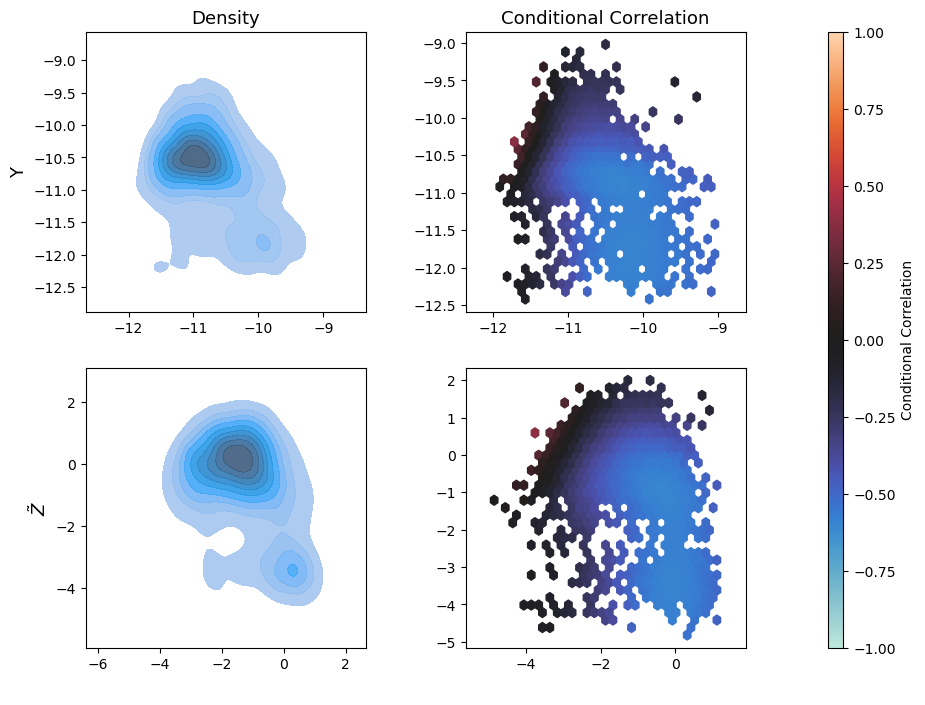

In [20]:
loaded_model_h.plot_conditional_dependence_pair(
    sample_indices,
    resampled_samples,
    show_colorbar=True,
    title=None,
    show_ticks=True,
    storage=None,
)

In [21]:
point_to_investigate = torch.FloatTensor(
    [
        -13.81944592,
        -13.39484714,
        -11.96498054,
        4.22107939,
        -0.97419929,
        -0.6324696,
        3.14861005,
        -1.63705064,
        -12.85096667,
        -5.3661742,
    ]
)

sample_indices = [5, 6]
fixed_values = dict()
for idx in range(0, 10):
    if idx not in sample_indices:
        fixed_values[idx] = point_to_investigate[idx]

In [22]:
resampled_samples = loaded_model_h.conditional_sample(
    number_proposed_samples=200000,
    sample_indices=[5, 6],
    sample_ranges=[(-5, 2), (-1, 7)],
    fixed_values=fixed_values,
)

864 samples where accepted.


/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_conditional_dependence_pair.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so 

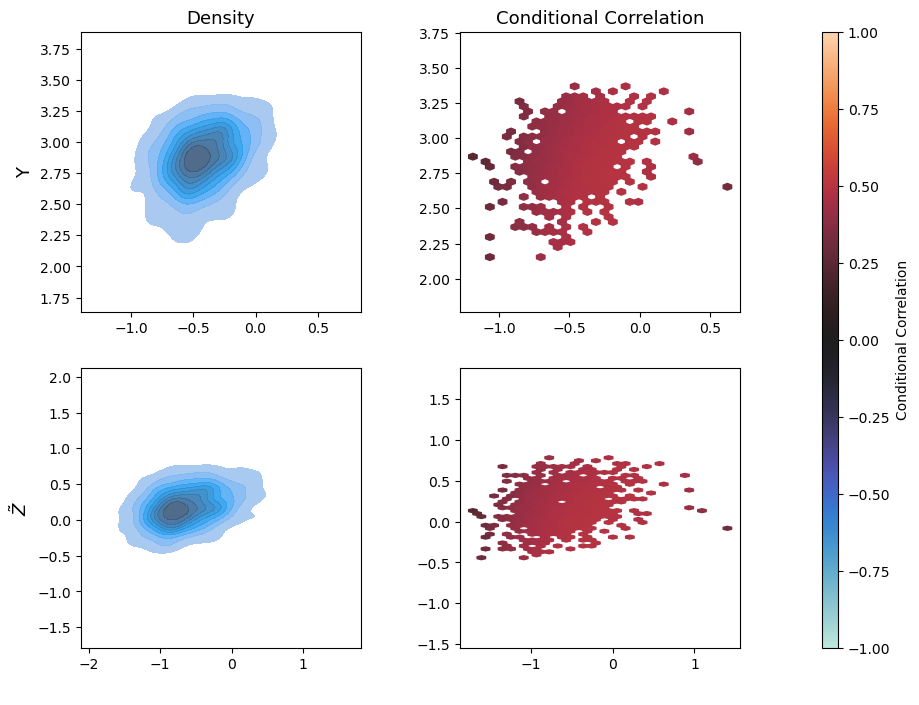

In [23]:
loaded_model_h.plot_conditional_dependence_pair(
    sample_indices,
    resampled_samples,
    show_colorbar=True,
    title=None,
    show_ticks=True,
    storage=None,
)